In [2]:
import os
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
print(torch.version.cuda)

11.8


In [4]:
#load saved files
fname = 0

with open(f'{fname}_x.pkl', 'rb') as f:
    firing_rates_all_stim = pickle.load(f)
    
with open(f'{fname}_y.pkl', 'rb') as f:
    y_np = pickle.load(f)

In [5]:
y_np.shape

(4435,)

In [6]:
firing_rates_all_stim.shape

(4435, 49, 252)

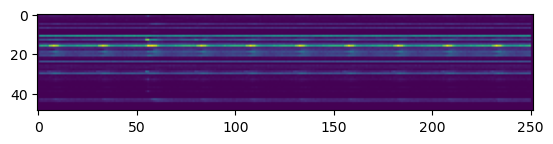

In [7]:
plt.imshow(np.mean(firing_rates_all_stim, axis = 0))

(array([32.,  8.,  2.,  5.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([9.92108230e-04, 2.25478241e+00, 4.50857272e+00, 6.76236302e+00,
        9.01615333e+00, 1.12699436e+01, 1.35237339e+01, 1.57775242e+01,
        1.80313145e+01, 2.02851048e+01, 2.25388952e+01]),
 <BarContainer object of 10 artists>)

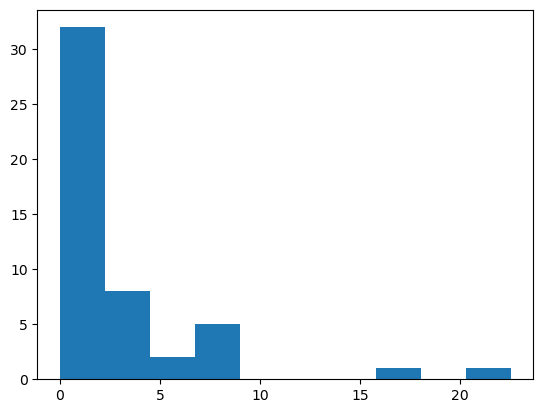

In [8]:
plt.hist(np.mean(np.sum(firing_rates_all_stim, axis = 2), axis = 0)/2.5)

In [9]:
firing_rates_all_stim.shape

(4435, 49, 252)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
print(torch.version.cuda)

11.8


In [12]:
#format data as tensor of reordered dims
firing_rates = torch.from_numpy(firing_rates_all_stim).permute(2, 0, 1) 
firing_rates = firing_rates.to(torch.float32)
firing_rates.shape

torch.Size([252, 4435, 49])

In [13]:
#train test split
train_split = .8
all_ids = np.arange(firing_rates.shape[1])
np.random.shuffle(all_ids)
train_ids = all_ids[0:int(len(all_ids) * train_split)]
test_ids = all_ids[int(len(all_ids) * train_split):-1]

In [14]:
# #get temp X: sum firing rate
# X = torch.sum(firing_rates, axis = 0)
# X.shape


In [15]:
#format y as one hot encoding
y = F.one_hot(torch.from_numpy(y_np))
y = y.to(torch.float32)

In [25]:
n_neurons = 49
n_bins = 252
n_comps = 10
output_cats = 4
# input_dim = n_neurons * n_bins
# input_dim

In [74]:
#define model architecture
class Net(nn.Module):
    def __init__(self, n_comps, n_neurons, output_cats):
        super(Net, self).__init__()
        
        #layers
        #1st conv -> relu -> maxpool block
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3, stride = 2),
            nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        )
        #2nd conv -> relu -> maxpool block
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 2),
            nn.MaxPool2d(kernel_size = (2, 2), stride = 2)
        )
        
        #add a dropout layer
        self.dropout = nn.Dropout(p = 0.2)
        #1st fully connected layer for flattened data
        self.fc1 = nn.Linear(960, n_comps)
        #2nd fully connected layer for dim reduction
        self.fc2 = nn.Linear(n_comps, output_cats)
    
    def forward(self, x):
        x = self.conv1(x)#conv
        x = self.conv2(x)#conv
        x = torch.flatten(x, 1) #flatten params
        x = self.dropout(x)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        return x

In [75]:
#param for dataloader
batch_size = 32

In [76]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class NeuralData(Dataset):
    def __init__(self, train = True):
        if train:
            self.firing_rate = firing_rates[:, train_ids, :]
            self.labels = y[train_ids]
        else:
            self.firing_rate = firing_rates[:, test_ids, :]
            self.labels = y[test_ids]
    
    def __len__(self):
        return self.labels.shape[0]

    def __getitem__(self, idx):
        rate = self.firing_rate[:, idx]
        # rate = torch.sum(self.firing_rate, axis = 0)[idx]
        label = self.labels[idx]
        return rate, label
    
train_data = NeuralData(train = True)
test_data = NeuralData(train = False)

train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle = False)

In [77]:
#params

#n of latent comps to try
n_comps = 5
output_cats = 4
n_neurons = firing_rates.shape[-1]
learning_rate = 1e-4
lambda_l2 = 5e-3
num_epochs = 200

In [78]:
#create model
model = Net(n_comps = n_comps, n_neurons = n_neurons, output_cats = output_cats)

In [79]:
#loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [80]:
loss_list = []
loss_increase = 0
prev_loss = 5
earlystop_criterion = 20 #how many iters of loss worsening before stopping

#add early stopping

#train
for epoch in tqdm.tqdm(range(num_epochs)):
    #iterate through train data
    for rate, label in train_loader:
        rate = rate.unsqueeze(1)
        # print(rate.shape, label.shape)
        #forward pass 
        pred = model(rate)
        
        l2 = 0
        for p in model.parameters():
            l2 += torch.sum(p ** 2)
        loss = criterion(pred, label) + lambda_l2 * l2
        loss_list.append(loss.item())
        
        #early stopping
        
        if loss > prev_loss:
            loss_increase += 1
            prev_loss = loss
            if loss_increase > earlystop_criterion:
                print(f'Early stop at epoch {epoch}, loss = {loss}, didn\'t improve for {earlystop_criterion} iterations')            
        else:
            loss_increase = 0
            prev_loss = loss
            
        
        #backprop
        optimizer.zero_grad() #zero out grads
        loss.backward() #calculate grad
        optimizer.step() #take step
        
        # # track accuracy
        # total = label.size(0)
        # _, predicted = torch.max(pred.data, 1)
        # correct = (predicted == label).sum().item()
        # acc_list.append(correct / total)
        
    print(f'epoch: {epoch}, loss: {loss}')

  0%|          | 1/200 [00:07<25:54,  7.81s/it]

epoch: 0, loss: 0.7454326152801514


  1%|          | 2/200 [00:14<24:28,  7.42s/it]

epoch: 1, loss: 0.6924464702606201


  2%|▏         | 3/200 [00:22<23:50,  7.26s/it]

epoch: 2, loss: 0.6455554366111755


  2%|▏         | 4/200 [00:29<23:33,  7.21s/it]

epoch: 3, loss: 0.34899991750717163


  2%|▎         | 5/200 [00:36<23:31,  7.24s/it]

epoch: 4, loss: 0.3871629238128662


  3%|▎         | 6/200 [00:43<23:31,  7.27s/it]

epoch: 5, loss: 0.1935085952281952


  4%|▎         | 7/200 [00:51<23:24,  7.28s/it]

epoch: 6, loss: 0.29681330919265747


  4%|▍         | 8/200 [00:58<23:06,  7.22s/it]

epoch: 7, loss: 0.22514253854751587


  4%|▍         | 9/200 [01:05<22:53,  7.19s/it]

epoch: 8, loss: 0.17492793500423431


  5%|▌         | 10/200 [01:12<22:37,  7.14s/it]

epoch: 9, loss: 0.17820584774017334


  6%|▌         | 11/200 [01:19<22:33,  7.16s/it]

epoch: 10, loss: 0.26655590534210205


  6%|▌         | 12/200 [01:26<22:22,  7.14s/it]

epoch: 11, loss: 0.3665783405303955


  6%|▋         | 13/200 [01:33<22:12,  7.13s/it]

epoch: 12, loss: 0.2013976126909256


  7%|▋         | 14/200 [01:40<22:04,  7.12s/it]

epoch: 13, loss: 0.186391681432724


  8%|▊         | 15/200 [01:48<22:19,  7.24s/it]

epoch: 14, loss: 0.23003502190113068


  8%|▊         | 16/200 [01:55<22:06,  7.21s/it]

epoch: 15, loss: 0.3168596029281616


  8%|▊         | 17/200 [02:02<22:08,  7.26s/it]

epoch: 16, loss: 0.13620701432228088


  9%|▉         | 18/200 [02:10<22:11,  7.32s/it]

epoch: 17, loss: 0.18987664580345154


 10%|▉         | 19/200 [02:17<21:54,  7.26s/it]

epoch: 18, loss: 0.14777475595474243


 10%|█         | 20/200 [02:24<21:39,  7.22s/it]

epoch: 19, loss: 0.1609210968017578


 10%|█         | 21/200 [02:31<21:25,  7.18s/it]

epoch: 20, loss: 0.12276969105005264


 11%|█         | 22/200 [02:38<21:13,  7.15s/it]

epoch: 21, loss: 0.1209777221083641


 12%|█▏        | 23/200 [02:45<21:08,  7.17s/it]

epoch: 22, loss: 0.2598244547843933


 12%|█▏        | 24/200 [02:53<21:13,  7.23s/it]

epoch: 23, loss: 0.16465641558170319


 12%|█▎        | 25/200 [03:00<21:01,  7.21s/it]

epoch: 24, loss: 0.27012908458709717


 13%|█▎        | 26/200 [03:07<20:48,  7.18s/it]

epoch: 25, loss: 0.1460454761981964


 14%|█▎        | 27/200 [03:14<20:43,  7.19s/it]

epoch: 26, loss: 0.15629202127456665


 14%|█▍        | 28/200 [03:21<20:30,  7.15s/it]

epoch: 27, loss: 0.12413652241230011


 14%|█▍        | 29/200 [03:29<20:22,  7.15s/it]

epoch: 28, loss: 0.10775300115346909


 15%|█▌        | 30/200 [03:36<20:12,  7.13s/it]

epoch: 29, loss: 0.3333660364151001


 16%|█▌        | 31/200 [03:43<20:06,  7.14s/it]

epoch: 30, loss: 0.28286704421043396


 16%|█▌        | 32/200 [03:50<19:58,  7.13s/it]

epoch: 31, loss: 0.14439579844474792


 16%|█▋        | 33/200 [03:57<19:55,  7.16s/it]

epoch: 32, loss: 0.18164077401161194


 17%|█▋        | 34/200 [04:04<19:56,  7.21s/it]

epoch: 33, loss: 0.12699788808822632


 18%|█▊        | 35/200 [04:12<19:46,  7.19s/it]

epoch: 34, loss: 0.09886030852794647


 18%|█▊        | 36/200 [04:19<19:35,  7.17s/it]

epoch: 35, loss: 0.09904608875513077


 18%|█▊        | 37/200 [04:26<19:22,  7.13s/it]

epoch: 36, loss: 0.09593945741653442


 19%|█▉        | 38/200 [04:33<19:11,  7.11s/it]

epoch: 37, loss: 0.1339760720729828


 20%|█▉        | 39/200 [04:40<19:18,  7.19s/it]

epoch: 38, loss: 0.16450810432434082


 20%|██        | 40/200 [04:47<19:14,  7.22s/it]

epoch: 39, loss: 0.11732019484043121


 20%|██        | 41/200 [04:55<19:02,  7.19s/it]

epoch: 40, loss: 0.1218884289264679


 21%|██        | 42/200 [05:02<18:51,  7.16s/it]

epoch: 41, loss: 0.1094248965382576


 22%|██▏       | 43/200 [05:09<18:49,  7.19s/it]

epoch: 42, loss: 0.11761005222797394


 22%|██▏       | 44/200 [05:16<18:42,  7.20s/it]

epoch: 43, loss: 0.10505417734384537


 22%|██▎       | 45/200 [05:24<18:45,  7.26s/it]

epoch: 44, loss: 0.09605377167463303


 23%|██▎       | 46/200 [05:32<19:29,  7.60s/it]

epoch: 45, loss: 0.09705587476491928


 24%|██▎       | 47/200 [05:41<20:28,  8.03s/it]

epoch: 46, loss: 0.10391069948673248


 24%|██▍       | 48/200 [05:50<21:13,  8.38s/it]

epoch: 47, loss: 0.09078094363212585


 24%|██▍       | 49/200 [05:58<20:48,  8.27s/it]

epoch: 48, loss: 0.11530296504497528


 25%|██▌       | 50/200 [06:06<20:12,  8.08s/it]

epoch: 49, loss: 0.10075969994068146


 26%|██▌       | 51/200 [06:14<20:16,  8.16s/it]

epoch: 50, loss: 0.08910022675991058


 26%|██▌       | 52/200 [06:22<19:31,  7.91s/it]

epoch: 51, loss: 0.15428711473941803


 26%|██▋       | 53/200 [06:29<18:49,  7.69s/it]

epoch: 52, loss: 0.09943114221096039


 27%|██▋       | 54/200 [06:36<18:19,  7.53s/it]

epoch: 53, loss: 0.276659220457077


 28%|██▊       | 55/200 [06:43<17:51,  7.39s/it]

epoch: 54, loss: 0.11047350615262985


 28%|██▊       | 56/200 [06:50<17:32,  7.31s/it]

epoch: 55, loss: 0.25358477234840393


 28%|██▊       | 57/200 [06:57<17:16,  7.25s/it]

epoch: 56, loss: 0.08664660155773163


 29%|██▉       | 58/200 [07:04<16:57,  7.17s/it]

epoch: 57, loss: 0.08804496377706528


 30%|██▉       | 59/200 [07:11<16:49,  7.16s/it]

epoch: 58, loss: 0.09070959687232971


 30%|███       | 60/200 [07:19<16:48,  7.20s/it]

epoch: 59, loss: 0.10577905923128128


 30%|███       | 61/200 [07:26<16:39,  7.19s/it]

epoch: 60, loss: 0.0910126119852066


 31%|███       | 62/200 [07:33<16:27,  7.16s/it]

epoch: 61, loss: 0.09171509742736816


 32%|███▏      | 63/200 [07:40<16:27,  7.21s/it]

epoch: 62, loss: 0.09555847942829132


 32%|███▏      | 64/200 [07:51<18:46,  8.28s/it]

epoch: 63, loss: 0.08037596940994263


 32%|███▎      | 65/200 [07:58<17:57,  7.98s/it]

epoch: 64, loss: 0.08933641761541367


 32%|███▎      | 65/200 [08:04<16:46,  7.46s/it]


KeyboardInterrupt: 

Text(0, 0.5, 'loss, cross entropy + L2')

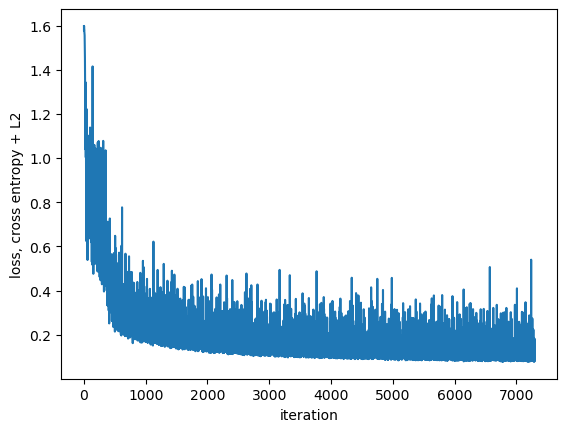

In [81]:
plt.plot(loss_list)
plt.xlabel('iteration')
plt.ylabel('loss, cross entropy + L2')

In [83]:
# testing
model.eval()
model.to(device)
real_labels, predicted_labels = [], []
with torch.no_grad():
  correct = 0
  total = 0
  for rate, labels in test_loader:
    #load labels
    rate, labels = rate.to(device), labels.to(device)
    rate = rate.unsqueeze(1)
    val, labels = torch.max(labels.data, 1)
    real_labels += list(labels.cpu().numpy())
    #get preds
    preds = model(rate)
    val, predicted = torch.max(preds.data, 1)
    predicted_labels += list(predicted.cpu().numpy())
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print(f"test acc from rates: {(correct / total)*100:.3f}%")

test acc from rates: 98.307%


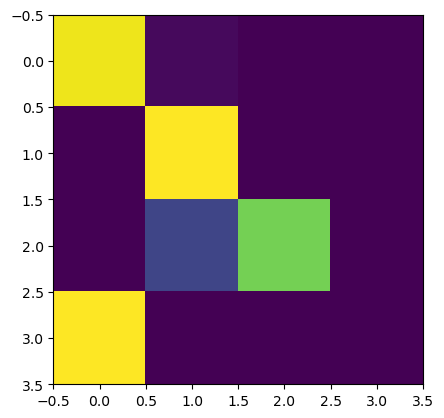

In [84]:
from sklearn.metrics import confusion_matrix

plt.imshow(confusion_matrix(real_labels, predicted_labels, normalize = 'true'))

In [86]:
confusion_matrix(real_labels, predicted_labels)

array([[122,   3,   0,   0],
       [  0, 719,   0,   0],
       [  0,   8,  30,   0],
       [  4,   0,   0,   0]], dtype=int64)

In [87]:
#save model just in case
with open('cnn_model.pkl', 'wb') as f:
    pickle.dump(model, f)

In [88]:
for i, layer in enumerate(model.parameters()):
    print(f'layer {i} num of params: {torch.numel(layer)}')

layer 0 num of params: 576
layer 1 num of params: 64
layer 2 num of params: 18432
layer 3 num of params: 32
layer 4 num of params: 4800
layer 5 num of params: 5
layer 6 num of params: 20
layer 7 num of params: 4
